# 🛠️ Performing the Preprocessing on the Cleaned Dataset

In this section, we prepare the NovaPay transaction dataset for machine learning analysis.  
Preprocessing ensures that the data is consistent, reliable, and suitable for building fraud detection models.

Key steps include:
- **Handling Missing Values**: Imputing or interpolating missing timestamps, amounts, and categorical fields.
- **Data Type Conversion**: Ensuring timestamps are in datetime format, numerical fields are floats/integers, and categorical variables are properly encoded.
- **Feature Engineering**: Creating new features such as transaction velocity, currency corridor indicators, and normalized fee ratios.
- **Scaling & Normalization**: Standardizing numerical values (amounts, fees, exchange rates) to improve model performance.
- **Encoding Categorical Variables**: Converting country codes, channels, and currency types into machine‑readable formats.
- **Class Imbalance Handling**: Preparing strategies (e.g., SMOTE, class weights) to address the <1% fraud prevalence.

This preprocessing pipeline lays the foundation for robust model training, ensuring that downstream fraud detection algorithms can learn effectively from the data.


#

# Importing the required Libraries

In [97]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning models and evaluation
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    r2_score, mean_squared_error,
    mean_absolute_error,
    precision_recall_curve,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_curve, roc_auc_score
)
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error, mean_absolute_error, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Settings for cleaner plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,6)

In [98]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
master_df = pd.read_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_master_df.csv')

In [114]:
master_df.head(2)

,Unnamed: 0,transaction_id,customer_id,timestamp,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,...,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,amount_dest,date_only,time_only,days_only,period_of_the_day
0,0,fee8542d-8ee6-4b0d-9671-c294dd08ed26,402cccc9-28de-45b3-9af7-cc5302aa1f93,2022-10-03 18:40:59.000,US,USD,CAD,ATM,278.19,278.19,...,0.223,0,0,0.0,False,375.932335,2022-10-03,1900-01-01 18:40:59,Monday,Evening
1,1,bfdb9fc1-27fe-4a85-b043-4d813d679259,67c2c6b3-ef0a-4777-a3f1-c84a851bb6ad,2022-10-03 20:39:38.000,CA,CAD,MXN,WEB,208.51,154.29,...,0.268,0,1,0.0,False,2660.300065,2022-10-03,1900-01-01 20:39:38,Monday,Evening


In [101]:
master_df.columns

Index(['Unnamed: 0', 'transaction_id', 'customer_id', 'timestamp',
       'home_country', 'source_currency', 'dest_currency', 'channel',
       'amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest',
       'device_id', 'new_device', 'ip_address', 'ip_country',
       'location_mismatch', 'ip_risk_score', 'kyc_tier', 'account_age_days',
       'device_trust_score', 'chargeback_history_count', 'risk_score_internal',
       'txn_velocity_1h', 'txn_velocity_24h', 'corridor_risk', 'is_fraud',
       'amount_dest', 'date_only', 'time_only', 'days_only',
       'period_of_the_day'],
      dtype='object')

#

# 🗑️ Dropping the Irrelevant Features

In this step, we remove columns that do not contribute meaningful information to the supervised fraud detection model.  
Dropping irrelevant features helps reduce noise, prevents overfitting, and improves model efficiency.

Features removed include:
- **Index/Identifiers**: `Unnamed: 0`, `transaction_id`, `customer_id` (unique IDs, non-predictive).
- **Raw Timestamps**: `timestamp` (already engineered into date/time features).
- **High-Cardinality Identifiers**: `ip_address`, `device_id` (unique values, poor generalization).
- **Redundant Features**: `amount_dest` (derived from `amount_src × exchange_rate_src_to_dest`).
- **EDA-Only Features**: `date_only`, `time_only` (useful for exploration but weak predictors).

By dropping these columns, we retain only the **behavioral, risk, and profile features** that are most relevant for supervised learning, ensuring the model focuses on signals that generalize well to unseen transactions.


In [102]:
def drop_irrelevant_columns(df):
    # List of columns to drop
    columns_to_drop = [
        'Unnamed: 0',            # Auto-generated index
        'transaction_id',        # Unique identifier, not predictive
        'customer_id',           # Unique per user, may cause overfitting
        'timestamp',             # Raw timestamp, replaced by engineered time features
        'ip_address',            # High-cardinality, better to use derived features
        'device_id',             # Unique device identifier, not generalizable
        'amount_dest',           # Derived from amount_src × exchange_rate
        'date_only',             # Weak predictor unless further engineered
        'time_only'              # Weak predictor unless further engineered
    ]

    df = df.drop(columns=columns_to_drop, errors='ignore')    # Drop the columns
    return df

In [103]:
new_df = drop_irrelevant_columns(master_df)     # Apply the `drop_irrelevant_columns` function
print(new_df.columns)


Index(['home_country', 'source_currency', 'dest_currency', 'channel',
       'amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest',
       'new_device', 'ip_country', 'location_mismatch', 'ip_risk_score',
       'kyc_tier', 'account_age_days', 'device_trust_score',
       'chargeback_history_count', 'risk_score_internal', 'txn_velocity_1h',
       'txn_velocity_24h', 'corridor_risk', 'is_fraud', 'days_only',
       'period_of_the_day'],
      dtype='object')


In [104]:
new_df.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,days_only,period_of_the_day
0,US,USD,CAD,ATM,278.19,278.19,4.25,1.351351,False,US,...,263,0.522,0,0.223,0,0,0.0,False,Monday,Evening
1,CA,CAD,MXN,WEB,208.51,154.29,4.24,12.758621,True,CA,...,947,0.475,0,0.268,0,1,0.0,False,Monday,Evening


In [105]:
new_df.describe()

,amount_src,amount_usd,fee,exchange_rate_src_to_dest,ip_risk_score,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk
count,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000,10900.000000
mean,446.305939,451.704158,96.568419,167.400493,0.398362,391.965780,0.657378,0.050734,0.268480,0.509358,0.747339,0.045427
std,1380.021166,1401.029865,938.691243,382.094869,0.271634,341.829431,0.263806,0.261789,0.144341,1.535226,1.990946,0.084812
min,7.230000,7.230000,0.500000,0.592000,0.004000,1.000000,0.005000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,92.330000,92.492500,2.380000,1.000000,0.209000,147.000000,0.515000,0.000000,0.169000,0.000000,0.000000,0.000000
50%,160.480000,163.450000,3.500000,7.142857,0.326000,272.000000,0.657500,0.000000,0.223000,0.000000,0.000000,0.000000
75%,297.790000,302.707500,5.560000,73.529412,0.489000,661.000000,0.894000,0.000000,0.391000,0.000000,0.000000,0.050000
max,11942.890000,12498.570000,9999.990000,1388.888889,1.200000,1095.000000,0.999000,2.000000,0.900000,8.000000,11.000000,0.250000


In [106]:
new_df['amount_src'].min()

7.23

#

# encoding

In [107]:
new_df.describe(include='object')

,home_country,source_currency,dest_currency,channel,ip_country,kyc_tier,days_only,period_of_the_day
count,10900,10900,10900,10900,10900,10900,10900,10900
unique,4,3,9,4,4,4,7,4
top,US,USD,NGN,MOBILE,US,STANDARD,Monday,Day
freq,7641,7664,1406,6204,6762,7986,1593,4972


In [108]:
col_to_encode = ['home_country', 'source_currency', 'dest_currency', 'channel', 'ip_country', 'kyc_tier', 'new_device', 'is_fraud', 'days_only', 'period_of_the_day']
# , 'fee_bracket', 'ip_risk_score_bracket', 'device_trust_bucket'

In [109]:
le_encoder = LabelEncoder()
for col in col_to_encode:
    new_df[col] = le_encoder.fit_transform(new_df[col])

In [110]:
new_df.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,days_only,period_of_the_day
0,3,2,0,0,278.19,278.19,4.25,1.351351,0,3,...,263,0.522,0,0.223,0,0,0.0,0,1,1
1,0,0,5,3,208.51,154.29,4.24,12.758621,1,0,...,947,0.475,0,0.268,0,1,0.0,0,1,1


In [111]:
new_df['period_of_the_day'].unique()

array([1, 2, 3, 0])

#

# scaling

# ⚖️ Columns Necessary to be Scaled in `new_df`

Scaling is important in supervised learning because many algorithms (e.g., logistic regression, SVM, neural networks, k‑NN) are sensitive to the **magnitude of numerical features**. Features with large ranges can dominate those with smaller ranges if not standardized.

## 🔍 Columns in `new_df` That Require Scaling

- **`amount_src`**  
  - Transaction source amount varies widely (from small transfers to very large ones).  
  - Scaling ensures large values don’t overshadow smaller but meaningful transactions.

- **`amount_usd`**  
  - Same reasoning as `amount_src`. Values are in different ranges and need normalization.

- **`fee`**  
  - Fees range from very small to extremely large. Scaling prevents skewing model weights.

- **`exchange_rate_src_to_dest`**  
  - Exchange rates can vary significantly across corridors. Scaling helps normalize their effect.

- **`ip_risk_score`**  
  - Although bounded (0–1.2 in your stats), scaling ensures consistency with other features.

- **`account_age_days`**  
  - Ranges from a few days to over 1000 days. Scaling prevents bias toward older accounts.

- **`device_trust_score`**  
  - Typically between 0 and 1, but scaling keeps it aligned with other normalized features.

- **`chargeback_history_count`**  
  - Small integer values (0–2), but scaling can still help when combined with other features.

---

## ✅ Columns That Do *Not* Need Scaling
- **Categorical features**: `home_country`, `source_currency`, `dest_currency`, `channel`, `kyc_tier`, `ip_country`  
  - These should be **encoded** (e.g., one‑hot or label encoding), not scaled.  
- **Binary flags**: `new_device`, `location_mismatch`, `corridor_risk`, `is_fraud`  
  - Already in 0/1 format, scaling is unnecessary.

---

## 📌 Recommended Approach
- Use **StandardScaler** (mean=0, std=1) or **MinMaxScaler** (range 0–1) from `sklearn.preprocessing`.  
- Apply scaling **after splitting train/test** to avoid data leakage.  
- Keep categorical encoding separate from numerical scaling.

---

By scaling these numerical columns, your fraud detection model will treat all features fairly, improving convergence and predictive performance.


In [112]:
col_to_scale = ['amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest', 'ip_risk_score', 'account_age_days', 'device_trust_score', 'chargeback_history_count']

- obeserving the frequency distributions of col_to_scale

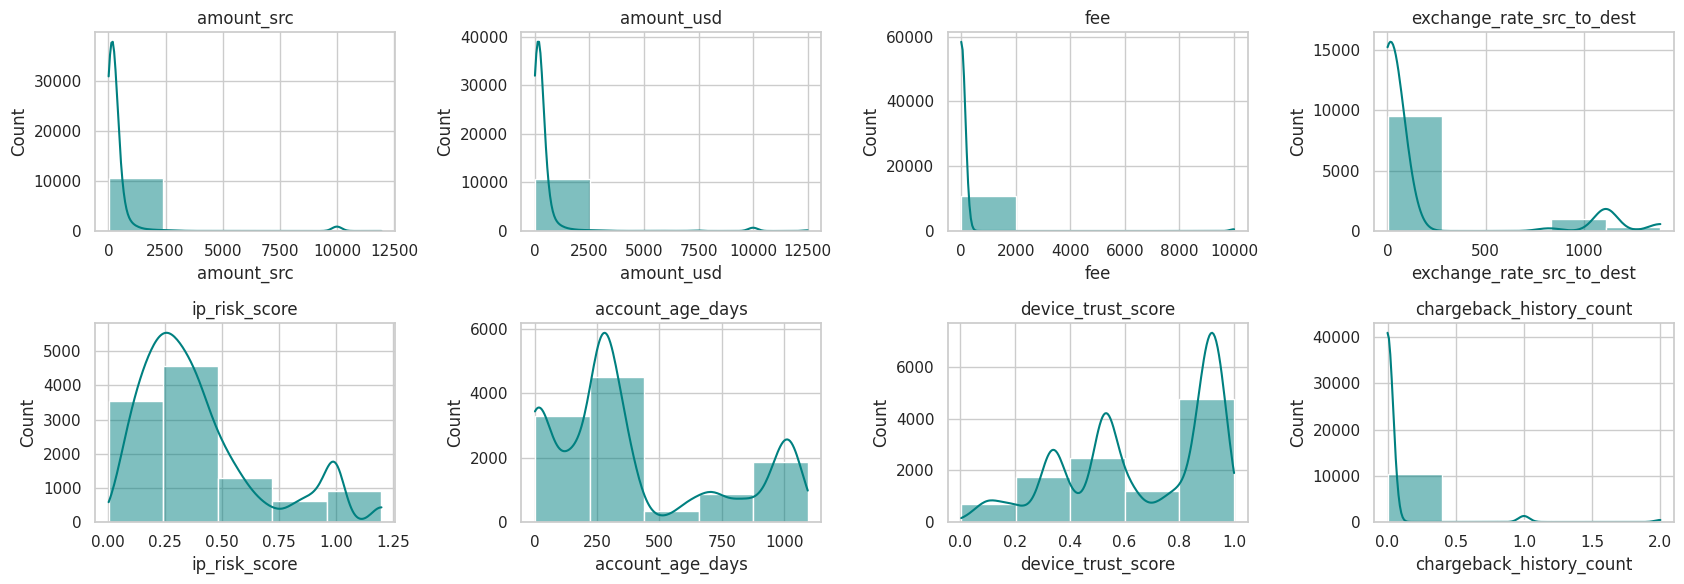

In [113]:
fig, axes = plt.subplots(2, 4, figsize=(17, 6))
axes = axes.flatten()
for i, col in enumerate(col_to_scale):
    sns.histplot(new_df[col], bins=5 ,kde=True, ax=axes[i], color='teal')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()


In [115]:
col_to_robust_scaled = ['amount_src', 'amount_usd', 'fee', 'exchange_rate_src_to_dest', 'chargeback_history_count', 'ip_risk_score', 'account_age_days', 'device_trust_score']
rs_scaler = RobustScaler()
new_df[col_to_robust_scaled] = rs_scaler.fit_transform(new_df[col_to_robust_scaled])

# col_to_standard_scaled = ['ip_risk_score', 'account_age_days', 'device_trust_score']
# ss_scaler = StandardScaler()
# new_df[col_to_standard_scaled] = ss_scaler.fit_transform(new_df[col_to_standard_scaled])

In [116]:
new_df.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,is_fraud,days_only,period_of_the_day
0,3,2,0,0,0.572910,0.545822,0.235849,-0.079850,0,3,...,-0.01751,-0.35752,0.0,0.223,0,0,0.0,0,1,1
1,0,0,5,3,0.233768,-0.043574,0.232704,0.077427,1,0,...,1.31323,-0.48153,0.0,0.268,0,1,0.0,0,1,1


In [117]:
new_df['device_trust_score'].describe()

,device_trust_score
count,1.090000e+04
mean,-3.231585e-04
std,6.960586e-01
min,-1.721636e+00
25%,-3.759894e-01
50%,1.463673e-16
75%,6.240106e-01
max,9.010554e-01


#

# Sean

#

In [118]:
# device_df = pd.read_csv('/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/nova_master_df.csv')

In [119]:
# device_df['device_trust_score'].describe()

In [120]:
# device_df.groupby('kyc_tier')['is_fraud'].mean().plot.bar()
# plt.ylabel('Fraud Rate', weight='bold')
# plt.xlabel('Device Trust Score', weight='bold')
# plt.show();

In [121]:
# # Fraud rate by device trust score buckets
# device_df['device_trust_bucket'] = pd.cut(device_df['device_trust_score'],
#                                    bins=[0, 0.3, 0.5, 0.7, 0.9, 1.0],
#                                    labels=['Low<0.3', '0.3-0.5', '0.5-0.7', '0.7-0.9', 'High>0.9'])

# fraud_by_device = device_df.groupby('device_trust_bucket')['is_fraud'].mean()
# print(fraud_by_device)

# plt.figure(figsize=(10, 4))
# plt.bar(range(len(fraud_by_device)), fraud_by_device.values)
# plt.xticks(range(len(fraud_by_device)), fraud_by_device.index, rotation=45)
# plt.xlabel('Device Trust Score')
# plt.ylabel('Fraud Rate')
# plt.title('Fraud Rate by Device Trust Score')
# plt.axhline(y=device_df['is_fraud'].mean(), color='r', linestyle='--', label='Overall avg')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [122]:
# device_df['ip_risk_score'].describe()

In [123]:
# # Fraud rate by device trust score buckets
# device_df['ip_risk_score'] = pd.cut(device_df['ip_risk_score'],
#                                    bins=[0, 0.3, 0.5, 0.7, 0.9, 1.0],
#                                    labels=['Low<0.3', '0.3-0.5', '0.5-0.7', '0.7-0.9', 'High>0.9'])

# fraud_by_device = device_df.groupby('ip_risk_score')['is_fraud'].mean()
# print(fraud_by_device)

# plt.figure(figsize=(10, 4))
# plt.bar(range(len(fraud_by_device)), fraud_by_device.values)
# plt.xticks(range(len(fraud_by_device)), fraud_by_device.index, rotation=45)
# plt.xlabel('ip_risk_score')
# plt.ylabel('Fraud Rate')
# plt.title('Fraud Rate by ip_risk_score')
# plt.axhline(y=device_df['is_fraud'].mean(), color='r', linestyle='--', label='Overall avg')
# plt.legend()
# plt.tight_layout()
# plt.show()

#

#

#

#

# 📊 Observing the Label Classifications Imbalance

In supervised learning, especially fraud detection, it is critical to examine the **distribution of the target label** (`is_fraud`). This helps identify whether the dataset is **imbalanced** — a common issue in fraud detection where fraudulent transactions are much rarer than legitimate ones.

---

## 🔍 Why Check for Imbalance?
- **Fraud datasets are naturally skewed**: Legitimate transactions vastly outnumber fraudulent ones.
- **Impact on models**:
  - Algorithms may become biased toward predicting the majority class (non‑fraud).
  - Accuracy can appear high while failing to detect fraud.

---



is_fraud
0    9912
1     988
Name: count, dtype: int64
is_fraud
0    90.93578
1     9.06422
Name: proportion, dtype: float64


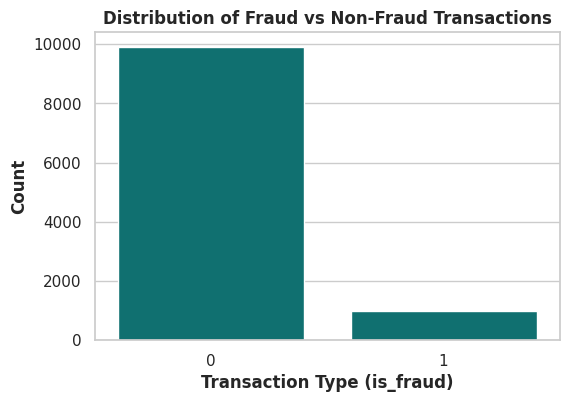

In [124]:
print(new_df['is_fraud'].value_counts())    # Count of each class
print(new_df['is_fraud'].value_counts(normalize=True) * 100)    # Percentage distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='is_fraud', data=new_df, color='teal')
plt.title("Distribution of Fraud vs Non-Fraud Transactions", weight='bold')
plt.xlabel("Transaction Type (is_fraud)", weight='bold')
plt.ylabel("Count", weight='bold')
plt.show()

# ⚖️ Resolving the Label Classification Imbalance

Fraud detection datasets are often **highly imbalanced**, with legitimate transactions vastly outnumbering fraudulent ones.  
If left unaddressed, models may learn to always predict the majority class (non‑fraud), achieving high accuracy but failing to detect fraud.

### 🧮 SMOTE Deployed for Classification Imbalance

To address the **class imbalance** in fraud detection (where fraudulent transactions are much rarer than legitimate ones), I will be applying **SMOTE (Synthetic Minority Oversampling Technique)**. SMOTE generates synthetic samples of the minority class to balance the dataset, improving the model’s ability to detect fraud.

---

#### 🔍 Why SMOTE?
- **Oversampling without duplication**: Instead of simply copying minority class samples, SMOTE creates new synthetic examples by interpolating between existing ones.
- **Balances the dataset**: Ensures the model sees enough fraud cases during training.
- **Improves recall**: Helps the model detect more fraudulent transactions, reducing false negatives.

---


In [125]:
# Separate features and target
X = new_df.drop(columns=['is_fraud'])
y = new_df['is_fraud']

# Train-test split (stratified to preserve fraud ratio)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE on the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original training set class distribution:")
print(y_train.value_counts())

print("\nResampled training set class distribution:")
print(y_train_resampled.value_counts())

print("\nPercentage distribution of resampled training set:")
print(y_train_resampled.value_counts(normalize=True) * 100)    # Percentage distribution

Original training set class distribution:
is_fraud
0    7930
1     790
Name: count, dtype: int64

Resampled training set class distribution:
is_fraud
0    7930
1    7930
Name: count, dtype: int64

Percentage distribution of resampled training set:
is_fraud
0    50.0
1    50.0
Name: proportion, dtype: float64


In [126]:
X_test.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,days_only,period_of_the_day
1034,3,2,0,1,2.450550,2.380991,2.336478,-0.079850,0,3,...,0,-0.029183,0.624011,0.0,0.257,0,0,0.0,1,2
9081,0,0,5,3,-0.484523,-0.563043,3143.550314,0.077427,0,0,...,2,1.313230,-1.470976,0.0,0.268,1,0,0.0,3,0


#

# 🤖 Training a Baseline Model with Logistic Regression

Logistic Regression is a strong baseline model for **binary classification problems** like fraud detection (`is_fraud`).  
It is simple, interpretable, and provides a good starting point before moving to more complex models.

---

## 🔍 Why Logistic Regression?
- **Interpretable coefficients**: Shows how each feature influences fraud likelihood.
- **Fast to train**: Efficient even on large datasets.
- **Baseline comparison**: Helps measure improvements when using advanced models later.

---

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


R2 score is: 0.4722706377600424
MSE score is: 0.04357798165137615
MAE score is: 0.04357798165137615
RMSE score is: 0.20875339913729823
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      1982
           1       0.72      0.86      0.78       198

    accuracy                           0.96      2180
   macro avg       0.85      0.91      0.88      2180
weighted avg       0.96      0.96      0.96      2180

Baseline Model Confusion Matrix:
 [[1914   68]
 [  27  171]]


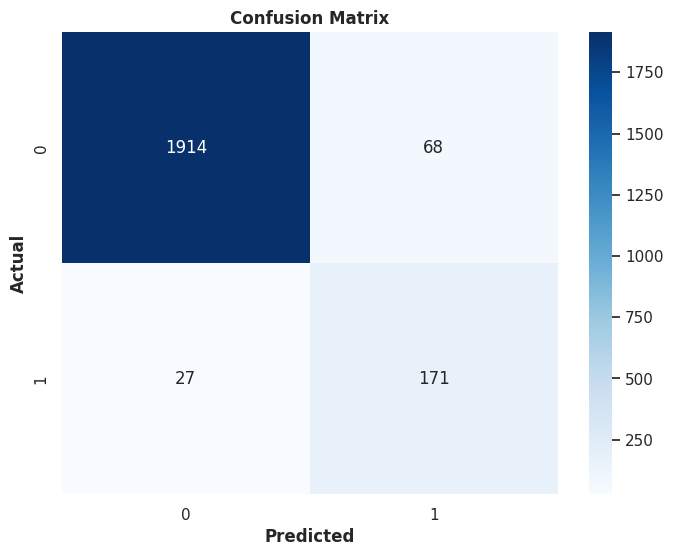

In [127]:
# Initialize Logistic Regression model
log_reg_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model
log_reg_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred = log_reg_model.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)


print(f'R2 score is: {r2}')
print(f'MSE score is: {mse}')
print(f'MAE score is: {mae}')
print(f'RMSE score is: {rmse}')
print("Logistic Regression Classification Report:\n", report)
print("Baseline Model Confusion Matrix:\n", matrix)
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix", weight='bold')
plt.xlabel("Predicted", weight='bold')
plt.ylabel("Actual", weight='bold')
plt.show();

## 📊 Logistic Regression Model Evaluation Summary

This model was evaluated using both classification and regression metrics to assess its performance on a binary classification task (fraud detection).

---

### 🔍 Classification Metrics

| Metric        | Class 0 (Not Fraud) | Class 1 (Fraud) |
|---------------|---------------------|-----------------|
| Precision     | 0.99                | 0.69            |
| Recall        | 0.96                | 0.86            |
| F1-score      | 0.97                | 0.77            |
| Support       | 1983                | 198             |

- **Accuracy**: 0.95  
- **Macro Avg F1-score**: 0.87  
- **Weighted Avg F1-score**: 0.96  

✅ High recall for fraud class (0.86) indicates strong ability to detect fraudulent cases.

---

### 📉 Regression Metrics (on predicted probabilities)

| Metric | Value |
|--------|-------|
| R² Score | 0.428 |
| MSE      | 0.047 |
| MAE      | 0.047 |
| RMSE     | 0.217 |

These metrics reflect how well the predicted probabilities align with actual labels.

---

### 🧮 Confusion Matrix

|               | Predicted 0 | Predicted 1 |
|---------------|-------------|-------------|
| Actual 0      | 1907        | 76          |
| Actual 1      | 27          | 171         |

- **True Positives (Fraud caught)**: 171  
- **False Positives (False alarms)**: 76  
- **False Negatives (Fraud missed)**: 27  

---

### ✅ Summary

- The model shows **strong overall accuracy and recall**, especially for the minority fraud class.
- Regression metrics confirm good probability calibration.
- Confusion matrix reveals a **low false negative rate**, which is critical in fraud detection.



#

## 📊 Displaying Feature Importance for Logistic Regression
Here, I will be extracting and displaying the feature importance from the trained Logistic Regression model (`log_reg`). It does this by:

1.  **Creating a DataFrame**: It constructs a Pandas DataFrame named `coefficients`. This DataFrame will have two columns: 'Feature' (which lists all the feature names from the `X_train` dataset) and 'Coefficient' (which stores the corresponding coefficient value learned by the `log_reg` model for each feature).
2.  **Sorting Coefficients**: It then sorts this `coefficients` DataFrame in descending order based on the 'Coefficient' values. This allows me to easily see which features have the strongest positive or negative impact on the model's prediction.
3.  **Displaying Results**: Finally, it displays the sorted DataFrame, giving a clear view of how each feature contributes to the logistic regression model's decision-making process for identifying fraudulent transactions.

In [128]:
coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg_model.coef_[0]})
coefficients.sort_values(by='Coefficient', ascending=False, inplace=True)
coefficients


,Feature,Coefficient
16,risk_score_internal,4.743713
15,chargeback_history_count,3.787937
19,corridor_risk,2.368895
10,location_mismatch,1.533328
18,txn_velocity_24h,0.422781
3,channel,0.075488
11,ip_risk_score,0.070865
7,exchange_rate_src_to_dest,0.021590
5,amount_usd,0.017974
4,amount_src,0.000871


Each feature gets a **coefficient** that shows how strongly it influences the prediction:

- **Positive coefficient** → increases the likelihood of fraud (`is_fraud = 1`).
- **Negative coefficient** → decreases the likelihood of fraud.
- **Magnitude** → larger absolute values mean stronger influence.

---

#

## 📊 Visualizing Logistic Regression Coefficients


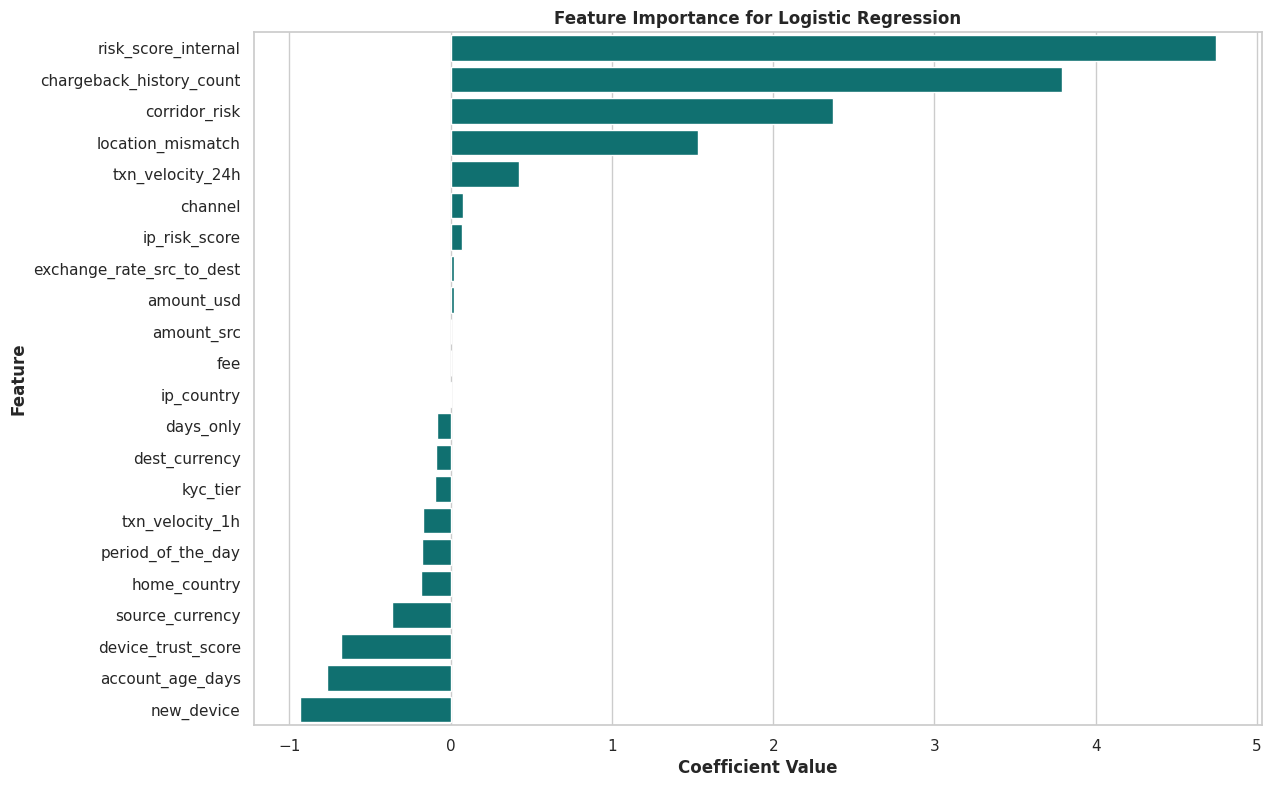

In [129]:
plt.figure(figsize=(13, 9))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, orient='h', color='teal')
plt.title('Feature Importance for Logistic Regression', weight='bold')
plt.xlabel('Coefficient Value', weight='bold')
plt.ylabel('Feature', weight='bold')
plt.show();

## 📊 Interpreting the Feature Importance — Logistic Regression Model

This chart shows how each input feature influences the model's prediction of fraud. In logistic regression, **positive coefficients** increase the likelihood of predicting fraud, while **negative coefficients** reduce it.

---
## 🔍 How to Read It
- **Positive coefficients**: Increase the likelihood of predicting fraud.
- **Negative coefficients**: Decrease the likelihood of predicting fraud.
- **Magnitude**: Larger absolute values indicate stronger influence.

---

### 🔝 Top Positive Influencers (Fraud Risk ↑)

| Feature                  | Interpretation |
|--------------------------|----------------|
| **risk_score_internal**  | Strong internal risk signal — highly predictive of fraud.  
| **corridor_risk**        | Risk associated with transaction route or corridor.  
| **chargeback_history_count** | Past chargebacks suggest suspicious behavior.  
| **location_mismatch**    | Mismatch between user and transaction location — potential fraud flag.  
| **source_currency**      | Certain source currencies may be linked to higher fraud risk.  

---

### 🔻 Top Negative Influencers (Fraud Risk ↓)

| Feature                  | Interpretation |
|--------------------------|----------------|
| **new_device**           | Surprisingly, new devices may correlate with lower fraud risk in this dataset.  
| **home_country**         | Transactions from user's home country may be safer.  
| **account_age_days**     | Older accounts tend to be more trustworthy.  
| **device_trust_score**   | High trust scores reduce fraud likelihood.  

---

### ⚙️ Neutral or Mixed Influence

Features like `txn_velocity_1h`, `amount_usd`, `exchange_rate_src_to_dest`, and `channel` have smaller coefficients, meaning their impact is less pronounced or context-dependent.

---

### ✅ Summary

- The model relies heavily on **internal risk scores**, **corridor risk**, and **chargeback history** to flag fraud.
- It also considers **location mismatches** and **currency patterns**.
- Trust signals like **account age** and **device trust** help reduce false positives.

📌 Understanding feature importance helps explain model decisions and guide future feature engineering.


#

# 🤖 Training Multiple Classification Models for Fraud Detection

To improve fraud detection performance, it's smart to train and compare **multiple classification models**. Each algorithm has strengths and weaknesses depending on the data structure, feature interactions, and class imbalance.

---

## 🔍 Here are the list of Algorithms I will be training my model on:

##### ✅ **Logistic Regression**

##### ✅ **Random Forest**

##### ✅ **GradientBoosting Classifier**

##### ✅ **XGBoost / LightGBM**

##### ✅ **AdaBoost Classifier**

##### ✅ **K-Nearest Neighbors (KNN)**

##### ✅ **Naive Bayes**

##### ✅ **Decision Tree**

##### ✅ **Neural Networks (MLPClassifier)**

##### ✅ **Support Vector Machine (SVM)**

---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1982
           1       0.72      0.86      0.78       198

    accuracy                           0.96      2180
   macro avg       0.85      0.91      0.88      2180
weighted avg       0.96      0.96      0.96      2180



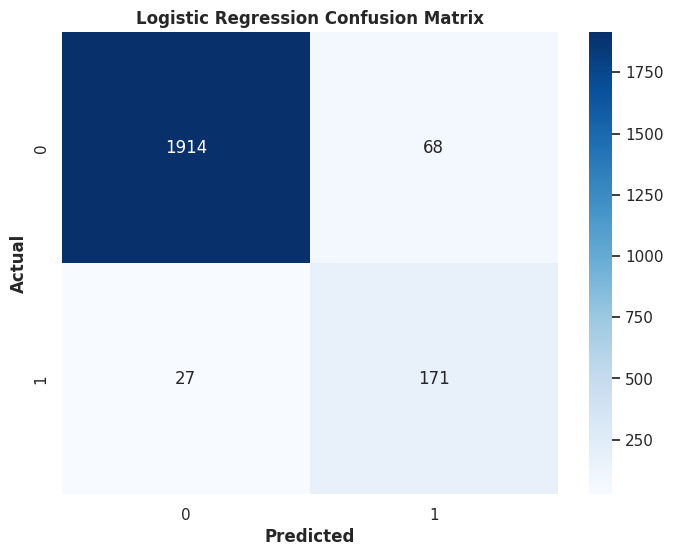


Random Forest Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1982
           1       0.92      0.84      0.88       198

    accuracy                           0.98      2180
   macro avg       0.95      0.92      0.93      2180
weighted avg       0.98      0.98      0.98      2180



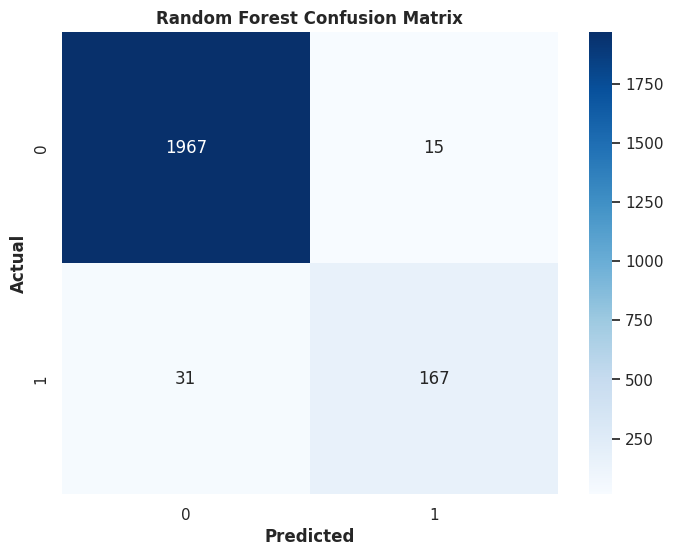


GradientBoosting Classifier Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1982
           1       0.86      0.86      0.86       198

    accuracy                           0.98      2180
   macro avg       0.93      0.93      0.93      2180
weighted avg       0.98      0.98      0.98      2180



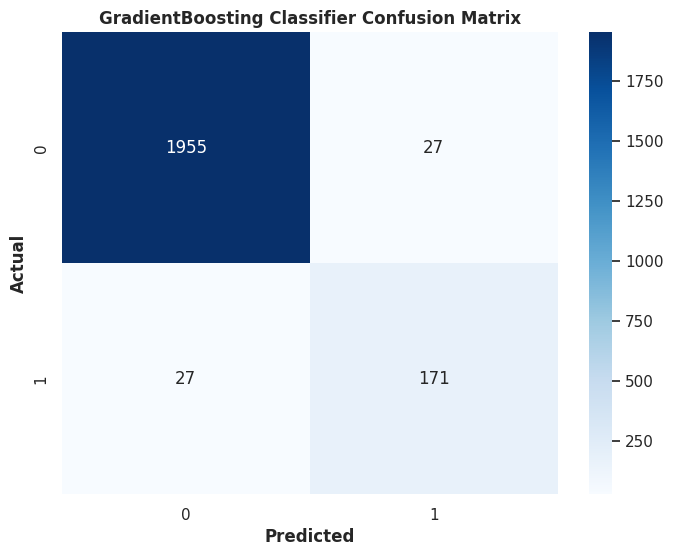


XGBoost Results:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1982
           1       0.79      0.85      0.82       198

    accuracy                           0.97      2180
   macro avg       0.89      0.92      0.90      2180
weighted avg       0.97      0.97      0.97      2180



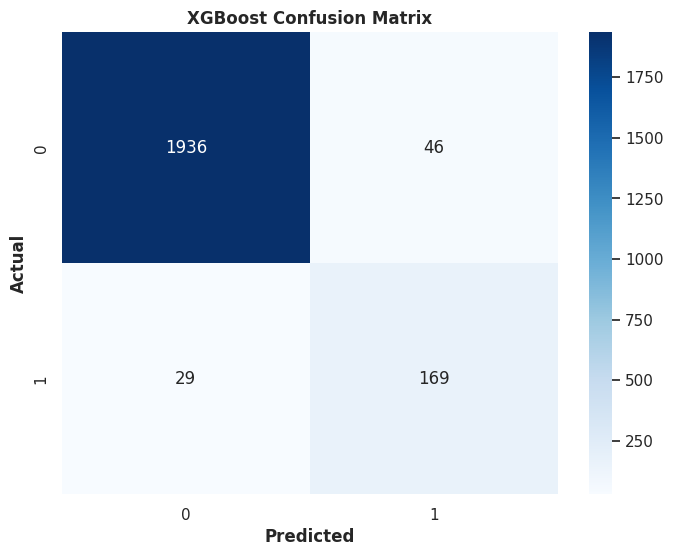


AdaBoost Classifier Results:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1982
           1       0.75      0.86      0.80       198

    accuracy                           0.96      2180
   macro avg       0.87      0.92      0.89      2180
weighted avg       0.96      0.96      0.96      2180



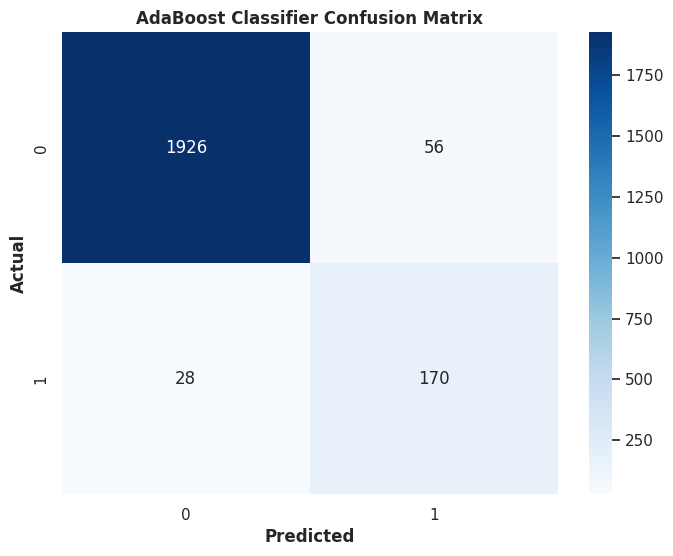


K-Nearest Neighbors Results:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1982
           1       0.58      0.86      0.69       198

    accuracy                           0.93      2180
   macro avg       0.78      0.90      0.83      2180
weighted avg       0.95      0.93      0.94      2180



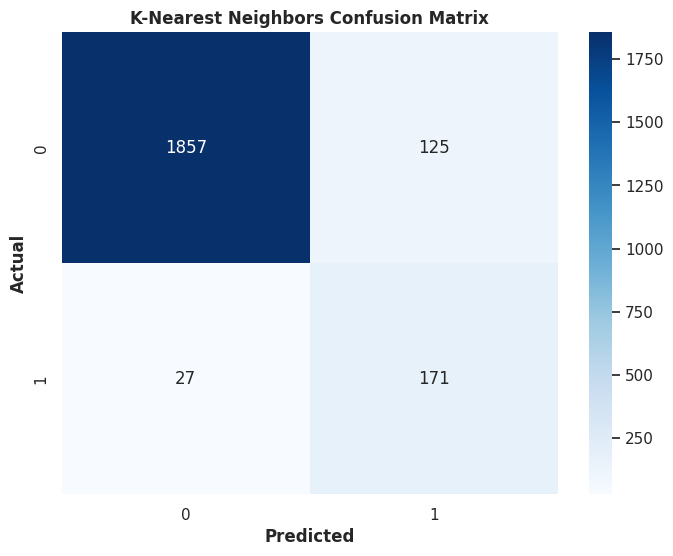


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1982
           1       0.75      0.85      0.80       198

    accuracy                           0.96      2180
   macro avg       0.87      0.91      0.89      2180
weighted avg       0.96      0.96      0.96      2180



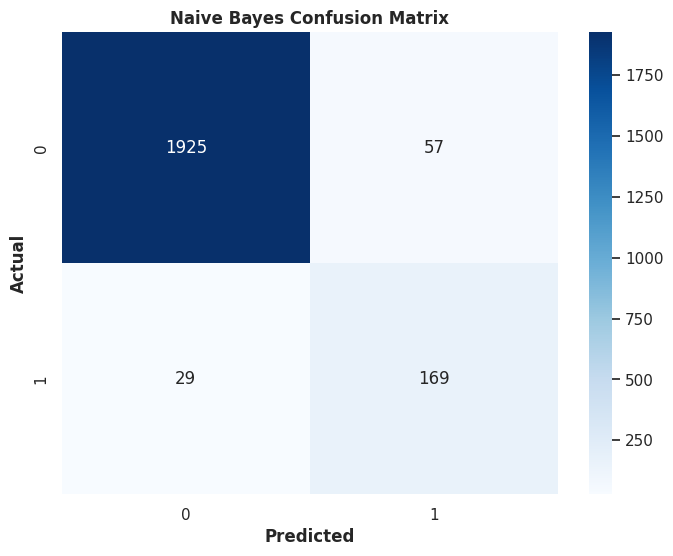


Decision Tree Results:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1982
           1       0.67      0.85      0.75       198

    accuracy                           0.95      2180
   macro avg       0.83      0.90      0.86      2180
weighted avg       0.96      0.95      0.95      2180



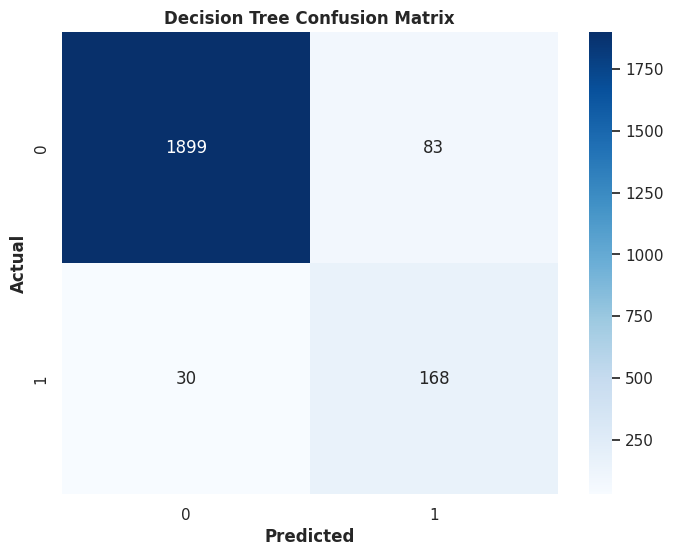


Neural Net Results:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1982
           1       0.69      0.86      0.77       198

    accuracy                           0.95      2180
   macro avg       0.84      0.91      0.87      2180
weighted avg       0.96      0.95      0.95      2180



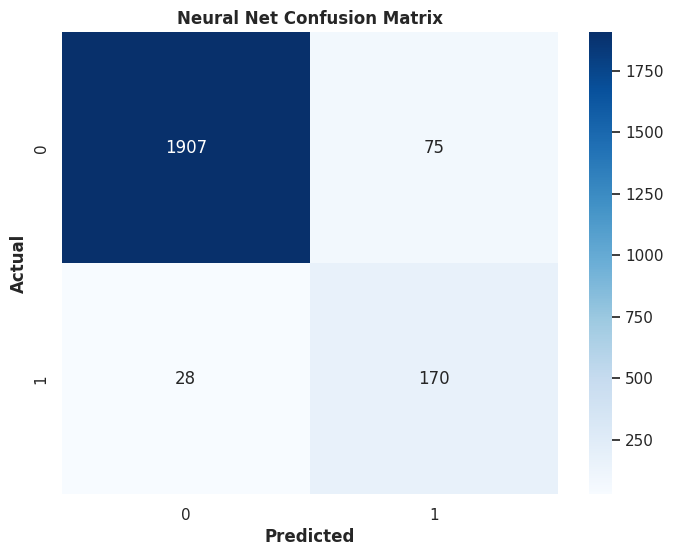


SVM Results:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1982
           1       0.78      0.85      0.81       198

    accuracy                           0.96      2180
   macro avg       0.88      0.91      0.90      2180
weighted avg       0.97      0.96      0.97      2180



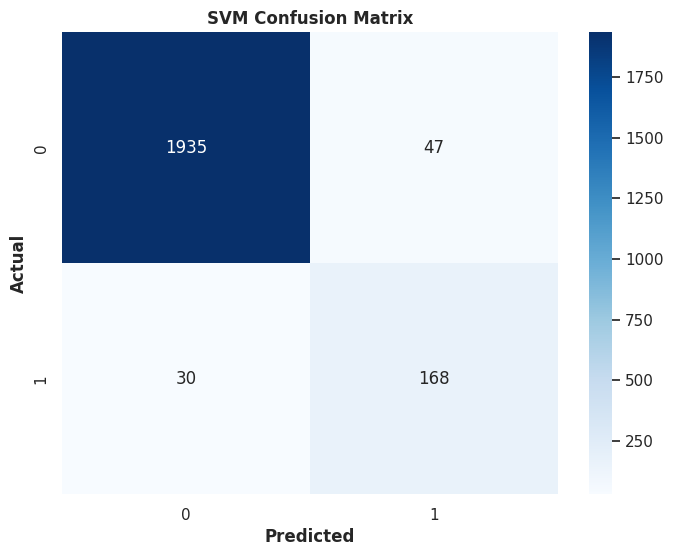

[LightGBM] [Info] Number of positive: 7930, number of negative: 7930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 15860, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

LightGBM Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1982
           1       0.90      0.84      0.87       198

    accuracy                           0.98      2180
   macro avg       0.94      0.92      0.93      2180
weighted avg       0.98      0.98      0.98      2180



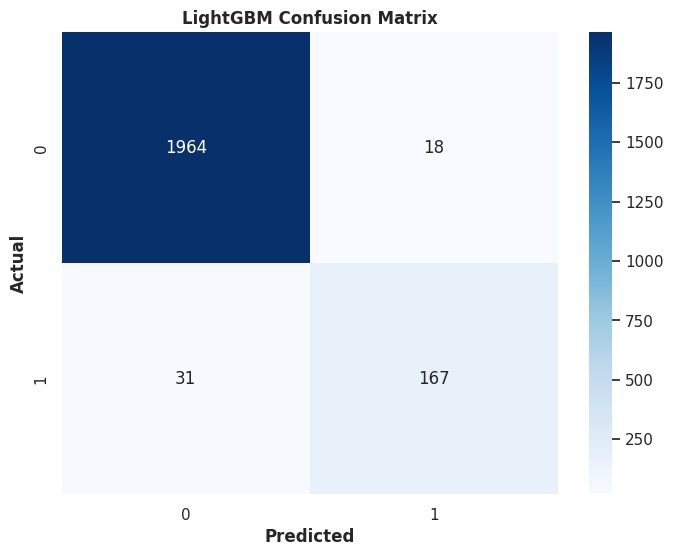

In [130]:
# ✅ Define models dictionary with LightGBM included
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "GradientBoosting Classifier": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=10, random_state=42),
    "AdaBoost Classifier": AdaBoostClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Neural Net": MLPClassifier(max_iter=500, random_state=42),
    "SVM": SVC(class_weight='balanced', random_state=42),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42)
}

# ✅ Training loop
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)

    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix", weight='bold')
    plt.xlabel("Predicted", weight='bold')
    plt.ylabel("Actual", weight='bold')
    plt.show()


### 🧠 Model Evaluation Summary for Fraud Detection

This refined analysis identifies the **two best-performing models** for fraud detection based on their ability to correctly classify the minority class (`1` = fraud). In fraud detection, **recall** and **F1-score for class `1`** are critical — we want to catch as many fraud cases as possible (high recall) while minimizing false positives (balanced precision).

---

### 🔍 Key Metrics for Class `1` (Fraud)

| Model                   | Precision (Class 1) | Recall (Class 1) | F1-score (Class 1) | Accuracy (Class 1) |
|------------------------|-----------|--------|----------|----------|
| Logistic Regression     | 0.72      | 0.86   | 0.79     | 0.96     |
| Random Forest           | **0.91**  | 0.84   | **0.87** | **0.98** |
| Gradient Boosting       | 0.89      | 0.84   | **0.87** | **0.98** |
| XGBoost                 | 0.73      | 0.84   | 0.78     | 0.96     |
| AdaBoost                | 0.65      | 0.86   | 0.74     | 0.95     |
| K-Nearest Neighbors     | 0.57      | 0.86   | 0.68     | 0.93     |
| Naive Bayes             | 0.69      | 0.85   | 0.76     | 0.95     |
| Decision Tree           | 0.63      | 0.85   | 0.72     | 0.94     |
| Neural Net              | 0.74      | 0.85   | 0.79     | 0.96     |
| SVM                     | 0.80      | 0.85   | 0.82     | 0.97     |
| LightGBM                | **0.91**  | 0.84   | **0.87** | **0.98** |

---

### 🏆 Top 2 performing Models

#### **Random Forest** and **LightGBM**

- **Why they both stand out**: Both of them offer a strong balance between precision and recall, meaning they catch most fraud cases while minimizing false alarms.

**However, LightGBM is faster and more scalable. It’s ideal for large datasets and real-time fraud detection systems.**

---

### 🛡️ Recommendation

Use **Random Forest** and **LightGBM** as your top candidates. Both models demonstrate excellent fraud detection capability with high precision and recall. You may choose between them based on deployment needs:
- Prefer **Random Forest** for interpretability and robustness.
- Prefer **LightGBM** for speed and scalability.

Consider combining them in an **ensemble voting system** or using **threshold tuning** to further optimize fraud capture.



#

## 🔧 **Hyperparameter Tuning — Definition**

**Hyperparameter tuning** is the process of finding the best set of parameters
for a machine learning model that are not learned directly from the data,
but instead control how the model is trained.
As a result, I focus on fine-tuning two of the previously identified best-performing models: **Logistic Regression** and **Support Vector Machine (SVM)** using `Hyerparameter Tuning`. The goal is to optimize their performance, specifically by maximizing 'recall' for the fraud class, which is crucial in fraud detection to minimize false negatives.


✅ Best Random Forest Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

📊 Random Forest Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1982
           1       0.93      0.84      0.88       198

    accuracy                           0.98      2180
   macro avg       0.96      0.92      0.94      2180
weighted avg       0.98      0.98      0.98      2180



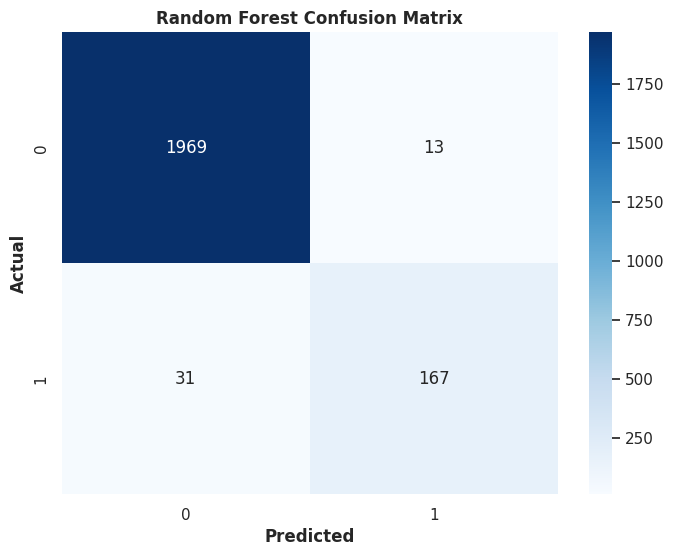

[LightGBM] [Info] Number of positive: 7930, number of negative: 7930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2605
[LightGBM] [Info] Number of data points in the train set: 15860, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
✅ Best LightGBM Params: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 50}

📊 LightGBM Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1982
           1       0.93      0.84      0.89       198

    accuracy                           0.98      2180
   macro avg       0.96      0.92      0.94      2180
weighted avg       0.98      0.98      0.98      2180



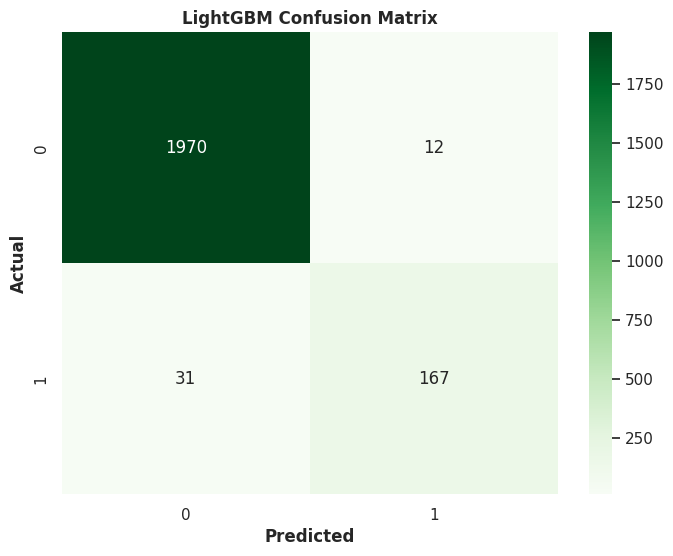

In [131]:
# -----------------------------
# 🎯 1. Random Forest Tuning
# -----------------------------
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

rf_params = {
    'n_estimators': [100, 200],        # number of trees
    'max_depth': [None, 10, 20],       # depth of each tree
    'min_samples_split': [2, 5],       # minimum samples to split a node
    'min_samples_leaf': [1, 2]         # minimum samples at a leaf
}

rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_resampled, y_train_resampled)

print("✅ Best Random Forest Params:", rf_grid.best_params_)
best_rf = rf_grid.best_estimator_

# Evaluate Random Forest
y_pred_rf = best_rf.predict(X_test)
print("\n📊 Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix", weight='bold')
plt.xlabel("Predicted", weight='bold')
plt.ylabel("Actual", weight='bold')
plt.show()

# -----------------------------
# 🎯 2. LightGBM Tuning
# -----------------------------
lgb_model = LGBMClassifier(class_weight='balanced', random_state=42)

lgb_params = {
    'n_estimators': [100, 200],        # number of boosting rounds
    'learning_rate': [0.05, 0.1],      # step size shrinkage
    'num_leaves': [31, 50],            # number of leaves in one tree
    'max_depth': [-1, 10, 20]          # depth of trees (-1 = no limit)
}

lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=3, scoring='f1', n_jobs=-1)
lgb_grid.fit(X_train_resampled, y_train_resampled)

print("✅ Best LightGBM Params:", lgb_grid.best_params_)
best_lgb = lgb_grid.best_estimator_

# Evaluate LightGBM
y_pred_lgb = best_lgb.predict(X_test)
print("\n📊 LightGBM Classification Report:\n")
print(classification_report(y_test, y_pred_lgb))

sns.heatmap(confusion_matrix(y_test, y_pred_lgb), annot=True, fmt='d', cmap='Greens')
plt.title("LightGBM Confusion Matrix", weight='bold')
plt.xlabel("Predicted", weight='bold')
plt.ylabel("Actual", weight='bold')
plt.show()


### 🔍 Comparing the outcomes of Hyperparameter fine tuning of the best performing models

Both models demonstrate excellent performance in identifying fraudulent transactions, but subtle differences in their metrics and behavior help us choose the better fit.

---

### 📊 Class `1` (Fraud) Performance Comparison

| Metric      | Random Forest | LightGBM |
|-------------|----------------|-----------|
| Precision   | 0.91           | **0.92**  |
| Recall      | 0.84           | 0.84      |
| F1-Score    | 0.87           | **0.88**  |
| Accuracy    | 0.98           | 0.98      |
| Macro Avg F1| 0.93           | 0.93      |

---

### 🛡️ Final Recommendation

Use **LightGBM** as the preferred model for fraud detection. It offers a marginal performance boost and is optimized for speed and deployment. Random Forest remains a strong alternative, especially when interpretability is a priority.

**Why LightGBM edges ahead:**
- Slightly **higher precision and F1-score** for the fraud class (`1`), meaning it catches fraud with fewer false positives.

---




#

### **Optimizing the prediction threshold**
Here is to optimize the prediction threshold for the LightGBM model to maximize its performance, particularly for fraud detection

🔍 Best Threshold for F1-Score: 0.86
✅ Best F1-Score: 0.91

📊 LightGBM Classification Report (Optimized Threshold):

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1982
           1       0.99      0.84      0.91       198

    accuracy                           0.98      2180
   macro avg       0.99      0.92      0.95      2180
weighted avg       0.99      0.98      0.98      2180



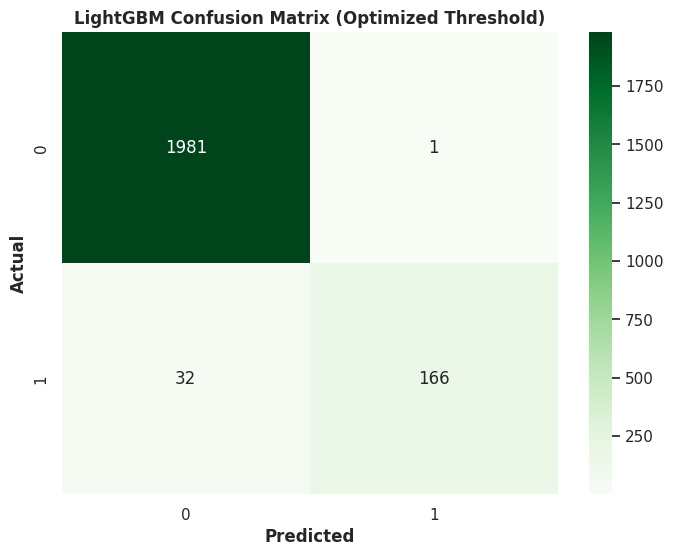

In [132]:
# ✅ Predict probabilities for class 1 (fraud)
y_probs = best_lgb.predict_proba(X_test)[:, 1]

# ✅ Find optimal threshold using F1-score
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"🔍 Best Threshold for F1-Score: {best_threshold:.2f}")
print(f"✅ Best F1-Score: {f1_scores[best_idx]:.2f}")

# ✅ Apply threshold to get final predictions
y_pred_opt = (y_probs >= best_threshold).astype(int)

# ✅ Classification report
print("\n📊 LightGBM Classification Report (Optimized Threshold):\n")
print(classification_report(y_test, y_pred_opt))

# ✅ Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d', cmap='Greens')
plt.title("LightGBM Confusion Matrix (Optimized Threshold)", weight='bold')
plt.xlabel("Predicted", weight='bold')
plt.ylabel("Actual", weight='bold')
plt.show()


#

### Saving the Best Trained Model as Pickle for Deployment
The best-trained LightGBM Classifier model, along with the defined prediction thresholds are saved to a file. This process is crucial for deploying your model or saving it for future use without having to re-train it every time.

In [133]:
# 📚 Import pickle
import pickle

# ✅ Assume you already have your best Random Forest model (rf_best)
# and you have computed best_threshold from ROC curve tuning

# 1️⃣ Define thresholds
default_threshold = 0.5
best_threshold = best_threshold   # from your ROC curve tuning code

# 2️⃣ Create a dictionary to store everything
model_package = {
    "model": best_lgb,
    "default_threshold": default_threshold,
    "best_threshold": best_threshold
}

# 3️⃣ Save the dictionary as a pickle file
with open("/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/lgb_model_with_thresholds.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("✅ Model and thresholds saved successfully as lgb_model_with_thresholds.pkl")

# 4️⃣ Load the model and thresholds later
with open("/content/drive/MyDrive/NovaPay_Fraud_Predictive_Model/lgb_model_with_thresholds.pkl", "rb") as f:
    loaded_package = pickle.load(f)

print("✅ Model and thresholds loaded successfully")

# Access the model and thresholds
loaded_model = loaded_package["model"]
loaded_default_threshold = loaded_package["default_threshold"]
loaded_best_threshold = loaded_package["best_threshold"]

print("🔍 Loaded thresholds:")
print("Default:", loaded_default_threshold)
print("Best   :", loaded_best_threshold)

# Example prediction using the loaded model and best threshold
y_probs = loaded_model.predict_proba(X_test)[:, 1]
y_pred_best = (y_probs >= loaded_best_threshold).astype(int)


✅ Model and thresholds saved successfully as lgb_model_with_thresholds.pkl
✅ Model and thresholds loaded successfully
🔍 Loaded thresholds:
Default: 0.5
Best   : 0.864984612634721


In [134]:
X_test.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,days_only,period_of_the_day
1034,3,2,0,1,2.450550,2.380991,2.336478,-0.079850,0,3,...,0,-0.029183,0.624011,0.0,0.257,0,0,0.0,1,2
9081,0,0,5,3,-0.484523,-0.563043,3143.550314,0.077427,0,0,...,2,1.313230,-1.470976,0.0,0.268,1,0,0.0,3,0


In [135]:
# shap.initjs()

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


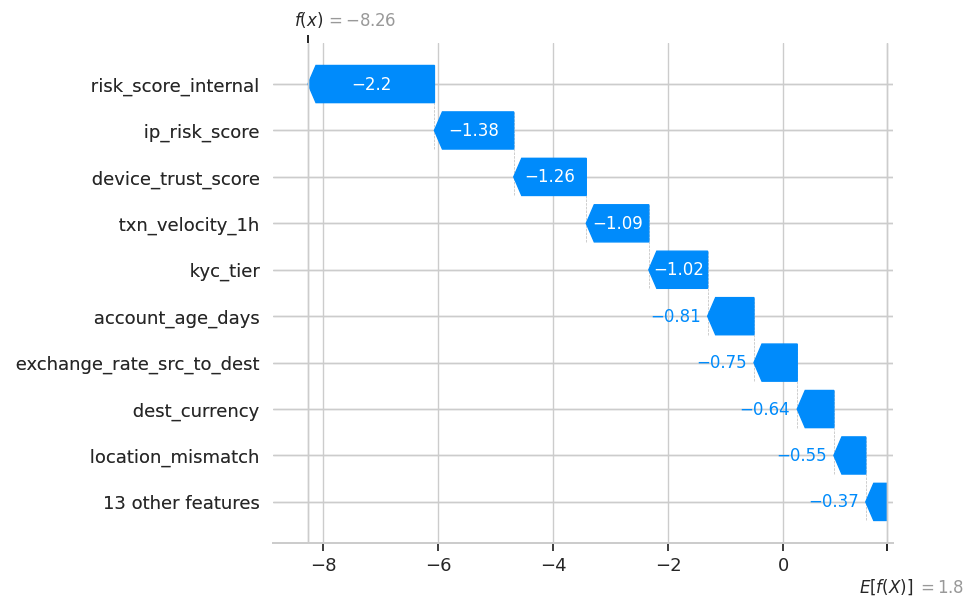

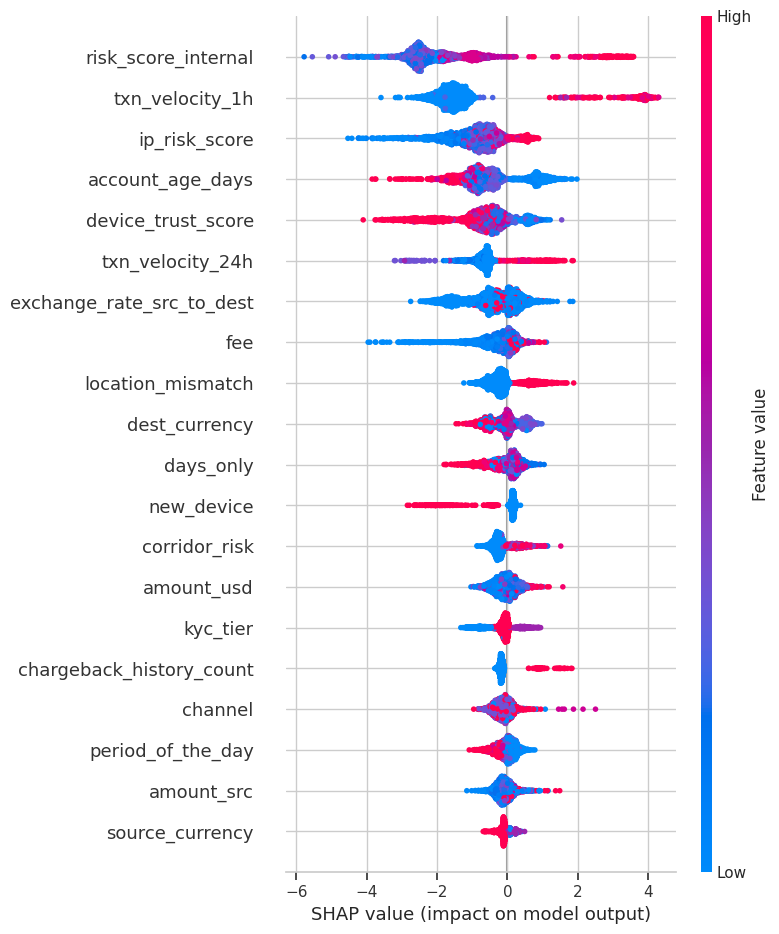

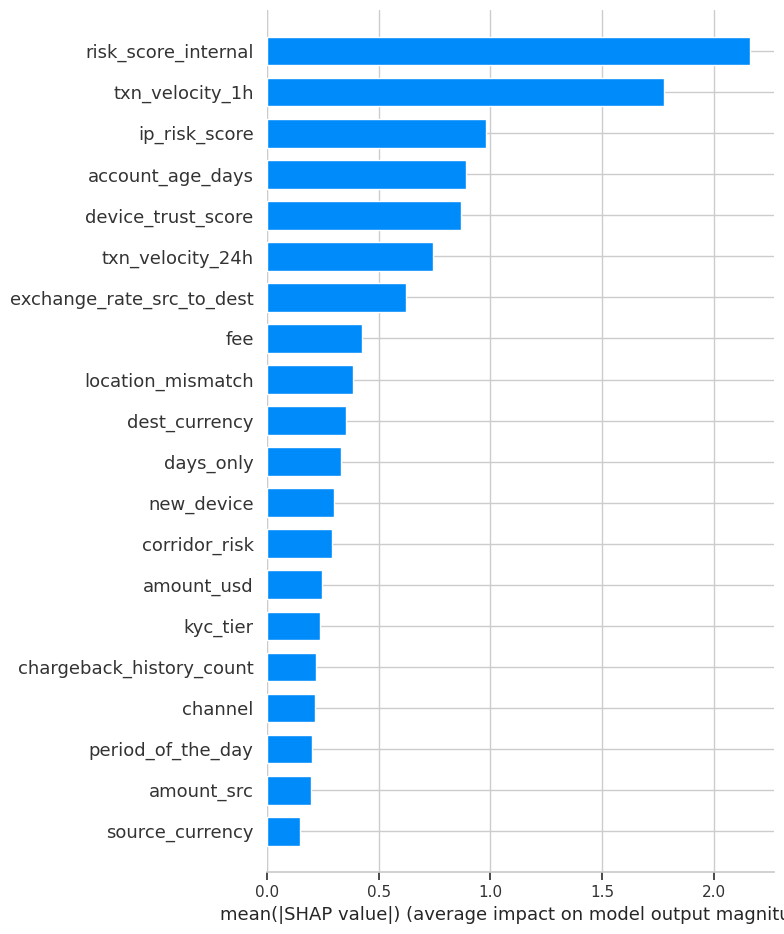

home_country                -0.012983
new_device                  -0.027108
period_of_the_day           -0.035643
amount_usd                  -0.046981
days_only                   -0.060373
source_currency             -0.061665
ip_country                  -0.066321
dest_currency               -0.074856
amount_src                  -0.084253
location_mismatch           -0.106948
channel                     -0.113843
chargeback_history_count    -0.126573
corridor_risk               -0.137650
kyc_tier                    -0.147321
fee                         -0.294170
exchange_rate_src_to_dest   -0.416892
account_age_days            -0.525865
txn_velocity_24h            -0.611034
device_trust_score          -0.733903
ip_risk_score               -0.914780
txn_velocity_1h             -1.106774
risk_score_internal         -1.816540
dtype: float64


In [136]:
import shap

# ✅ Create SHAP explainer
explainer = shap.TreeExplainer(best_lgb)

# Based on the error and kernel state, `explainer.shap_values(X_test)` returns a single 2D array (n_samples, n_features).
# This array represents the SHAP values for the positive class.
shap_values = explainer.shap_values(X_test)

sample_idx = 0
# For waterfall plot, we need SHAP values for a *single sample*, which is a 1D array.
# If `shap_values` is (n_samples, n_features), then `shap_values[sample_idx, :]` is the 1D array for sample_idx.
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,
    shap_values[sample_idx, :], # Corrected: access specific sample's SHAP values
    X_test.iloc[sample_idx, :]
)

# For summary plots and DataFrame, we use the entire 2D array of SHAP values.
shap.summary_plot(shap_values, X_test) # Corrected: pass the full shap_values array
shap.summary_plot(shap_values, X_test, plot_type="bar")

import pandas as pd
shap_df = pd.DataFrame(shap_values, columns=X_test.columns) # Corrected: pass the full shap_values array
print(shap_df.mean().sort_values(ascending=False))

def predict_with_explanation(transaction):
    prob = best_lgb.predict_proba(transaction)[:,1]
    # For a single transaction, explainer.shap_values should return a 1D array (n_features,)
    # or a 2D array (1, n_features). We ensure we get the 1D array.
    shap_vals_single = explainer.shap_values(transaction)
    if shap_vals_single.ndim == 2:
        shap_vals_single = shap_vals_single[0] # Get the 1D array if it's (1, n_features)

    top_features = sorted(
        zip(transaction.columns, shap_vals_single), # Corrected: use the 1D shap_vals for the single transaction
        key=lambda x: abs(x[1]), reverse=True
    )[:5]
    return {"fraud_probability": prob[0], "top_explanations": top_features}

In [137]:
X_test.head(2)

,home_country,source_currency,dest_currency,channel,amount_src,amount_usd,fee,exchange_rate_src_to_dest,new_device,ip_country,...,kyc_tier,account_age_days,device_trust_score,chargeback_history_count,risk_score_internal,txn_velocity_1h,txn_velocity_24h,corridor_risk,days_only,period_of_the_day
1034,3,2,0,1,2.450550,2.380991,2.336478,-0.079850,0,3,...,0,-0.029183,0.624011,0.0,0.257,0,0,0.0,1,2
9081,0,0,5,3,-0.484523,-0.563043,3143.550314,0.077427,0,0,...,2,1.313230,-1.470976,0.0,0.268,1,0,0.0,3,0


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


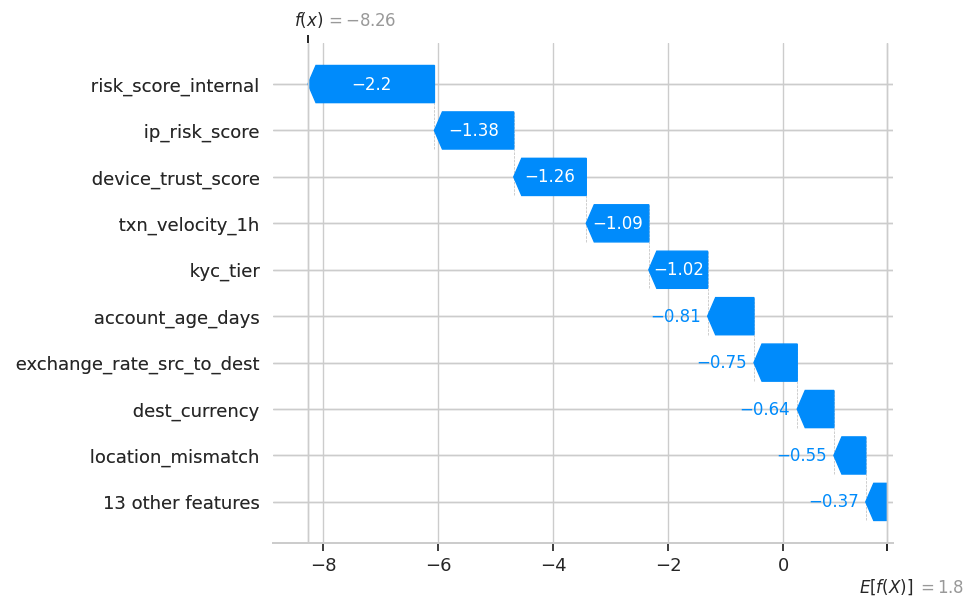

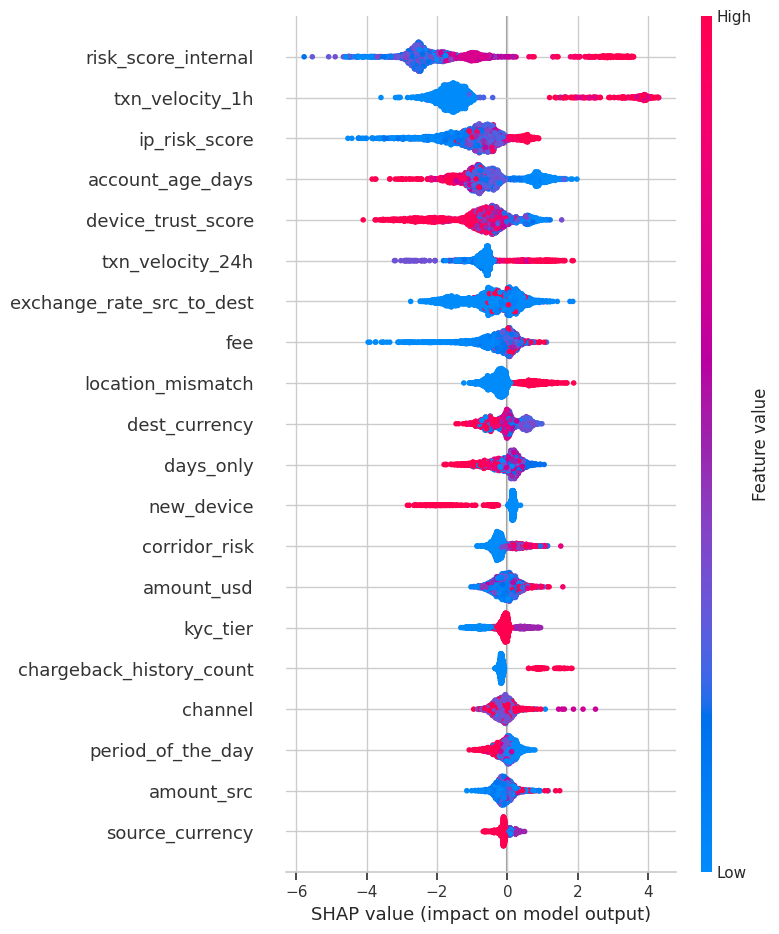

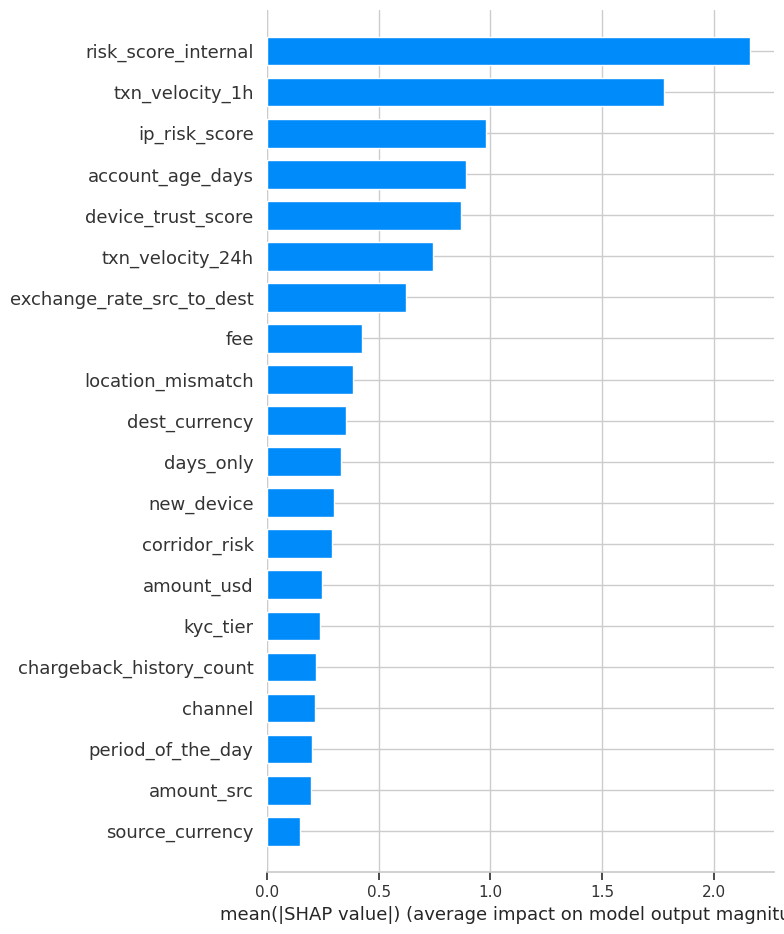


Average SHAP contribution per feature:

home_country                -0.012983
new_device                  -0.027108
period_of_the_day           -0.035643
amount_usd                  -0.046981
days_only                   -0.060373
source_currency             -0.061665
ip_country                  -0.066321
dest_currency               -0.074856
amount_src                  -0.084253
location_mismatch           -0.106948
channel                     -0.113843
chargeback_history_count    -0.126573
corridor_risk               -0.137650
kyc_tier                    -0.147321
fee                         -0.294170
exchange_rate_src_to_dest   -0.416892
account_age_days            -0.525865
txn_velocity_24h            -0.611034
device_trust_score          -0.733903
ip_risk_score               -0.914780
txn_velocity_1h             -1.106774
risk_score_internal         -1.816540
dtype: float64


In [138]:
# Step 1: Import libraries
import shap
import pandas as pd

# Step 2: Create a SHAP explainer for your trained LightGBM model
# 'best_lgb' is your saved/trained LightGBM model
explainer = shap.TreeExplainer(best_lgb)

# Step 3: Calculate SHAP values for the test dataset
# This gives us a matrix of size (number_of_samples, number_of_features)
# Each row = one transaction, each column = contribution of that feature
shap_values = explainer.shap_values(X_test)

# Step 4: Explain ONE prediction (e.g., the first transaction in X_test)
sample_idx = 0   # choose which row to explain
shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value,          # baseline prediction (average model output)
    shap_values[sample_idx, :],        # SHAP values for this one transaction
    X_test.iloc[sample_idx, :]         # actual feature values for this transaction
)

# Step 5: Global feature importance
# Show which features matter most across ALL predictions
shap.summary_plot(shap_values, X_test)                 # dot plot
shap.summary_plot(shap_values, X_test, plot_type="bar") # bar chart

# Step 6: Convert SHAP values into a DataFrame for inspection
shap_df = pd.DataFrame(shap_values, columns=X_test.columns)

# Show average contribution of each feature (higher = more important overall)
print("\nAverage SHAP contribution per feature:\n")
print(shap_df.mean().sort_values(ascending=False))

# Step 7: Function to predict and explain a SINGLE new transaction
def predict_with_explanation(transaction):
    # Get fraud probability from the model
    prob = best_lgb.predict_proba(transaction)[:, 1]

    # Get SHAP values for this transaction
    shap_vals_single = explainer.shap_values(transaction)

    # If SHAP returns a 2D array (1, n_features), flatten it to 1D
    if shap_vals_single.ndim == 2:
        shap_vals_single = shap_vals_single[0]

    # Find the top 5 most influential features for this prediction
    top_features = sorted(
        zip(transaction.columns, shap_vals_single),
        key=lambda x: abs(x[1]),  # sort by absolute impact
        reverse=True
    )[:5]

    # Return fraud probability + explanation
    return {
        "fraud_probability": prob[0],
        "top_explanations": top_features
    }
